In [2]:
# Mount Google Drive
#from google.colab import drive
#drive.mount('/content/gdrive')

#  from google.colab import files
#  files.upload()

# !rm -r ~/.Kaggle

# !mkdir ~/.kaggle

# !mv ./kaggle.json ~/.kaggle/

# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle datasets download -d salader/dogs-vs-cats

# !cp /content/dogs-vs-cats.zip /content/gdrive/MyDrive/dog_cat/dogs-vs-cats.zip


In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

In [5]:
!kaggle datasets download -d salader/dogs-vs-cats

 99% 1.05G/1.06G [00:05<00:00, 251MB/s]
100% 1.06G/1.06G [00:05<00:00, 209MB/s]


In [7]:
import zipfile
zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
import os
import random
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

In [10]:
# Generators
train_ds = keras.utils.image_dataset_from_directory(
    directory='/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory='/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=64,
    image_size=(256, 256)
)

# Print class names and class indices
class_names = train_ds.class_names
print("Class Names:", class_names)

# If you still want class indices, you can use the class_names list
class_indices = {class_name: index for index, class_name in enumerate(class_names)}
print("Class Indices:", class_indices)


Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Class Names: ['cats', 'dogs']
Class Indices: {'cats': 0, 'dogs': 1}


In [11]:
# Initialize counters
total_cat_images_train = 0
total_dog_images_train = 0
total_cat_images_validation = 0
total_dog_images_validation = 0

In [12]:
# Iterate through training & validation dataset
for _, labels in train_ds:
    total_cat_images_train += sum(labels.numpy() == class_indices['cats'])
    total_dog_images_train += sum(labels.numpy() == class_indices['dogs'])

In [13]:
for _, labels in validation_ds:
    total_cat_images_validation += sum(labels.numpy() == class_indices['cats'])
    total_dog_images_validation += sum(labels.numpy() == class_indices['dogs'])

In [14]:
print("Total Cat Images in Training Dataset:", total_cat_images_train)
print("Total Dog Images in Training Dataset:", total_dog_images_train)
print("Total Cat Images in Validation Dataset:", total_cat_images_validation)
print("Total Dog Images in Validation Dataset:", total_dog_images_validation)

Total Cat Images in Training Dataset: 10000
Total Dog Images in Training Dataset: 10000
Total Cat Images in Validation Dataset: 2500
Total Dog Images in Validation Dataset: 2500


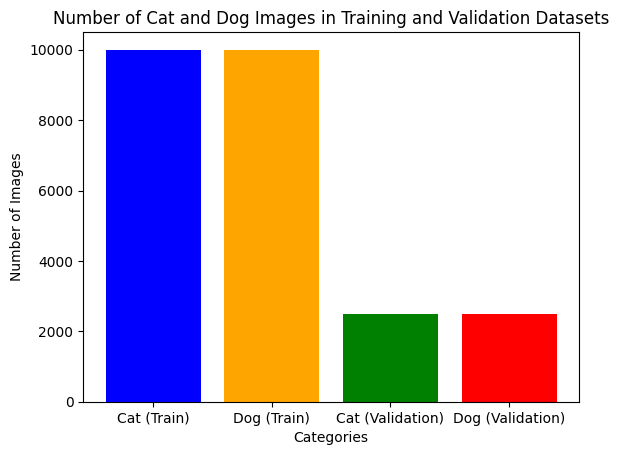

In [15]:
categories = ['Cat (Train)', 'Dog (Train)', 'Cat (Validation)', 'Dog (Validation)']
counts = [total_cat_images_train, total_dog_images_train, total_cat_images_validation, total_dog_images_validation]

plt.bar(categories, counts, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Cat and Dog Images in Training and Validation Datasets')
plt.show()


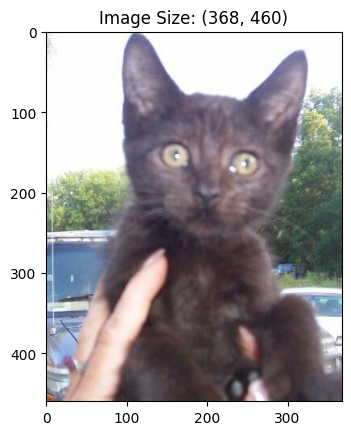

In [17]:
directory = '/content/train/cats'
filenames = os.listdir(directory)

sample = random.choice(filenames)
image_path = os.path.join(directory, sample)
image = load_img(image_path)

plt.imshow(image)
plt.title(f"Image Size: {image.size}")
plt.show()


In [18]:
#normalize
def process(image,label):
  image = tf.cast(image/255.0, tf.float32)
  return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

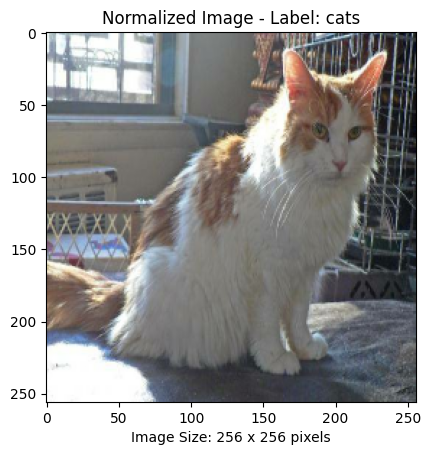

In [19]:
# Display a normalized image
def display_normalized_image(dataset):
    for images, labels in dataset.take(1):
        normalized_image = images[0].numpy()
        label = class_names[labels[0]]

        plt.imshow(normalized_image)
        plt.title(f"Normalized Image - Label: {label}")

        plt.xlabel(f"Image Size: {normalized_image.shape[0]} x {normalized_image.shape[1]} pixels")
        plt.show()

display_normalized_image(validation_ds)


In [21]:
# Create CNN model
model = Sequential()

# Input Layer
model.add(Conv2D(10, kernel_size=(3, 3), padding='valid', activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Convolutional Layers with Max Pooling
model.add(Conv2D(20, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(40, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

model.add(Conv2D(80, kernel_size=(3, 3), padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid'))

# Flatten Layer
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(80, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification, so use sigmoid in the output layer


In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 10)      280       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 10)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 20)      1820      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 20)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 40)        7240      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 40)        0

In [25]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
313/313 [==============================] - 71s 177ms/step - loss: 0.6778 - accuracy: 0.5567 - val_loss: 0.6192 - val_accuracy: 0.6652
Epoch 2/10
313/313 [==============================] - 53s 167ms/step - loss: 0.5860 - accuracy: 0.6877 - val_loss: 0.5451 - val_accuracy: 0.7224
Epoch 3/10
313/313 [==============================] - 53s 162ms/step - loss: 0.5357 - accuracy: 0.7279 - val_loss: 0.5229 - val_accuracy: 0.7406
Epoch 4/10
313/313 [==============================] - 49s 154ms/step - loss: 0.5121 - accuracy: 0.7455 - val_loss: 0.5001 - val_accuracy: 0.7600
Epoch 5/10
313/313 [==============================] - 51s 160ms/step - loss: 0.4833 - accuracy: 0.7674 - val_loss: 0.4741 - val_accuracy: 0.7804
Epoch 6/10
313/313 [==============================] - 52s 165ms/step - loss: 0.4625 - accuracy: 0.7807 - val_loss: 0.4626 - val_accuracy: 0.7894
Epoch 7/10
313/313 [==============================] - 64s 201ms/step - loss: 0.4392 - accuracy: 0.7947 - val_loss: 0.4541 - val_ac

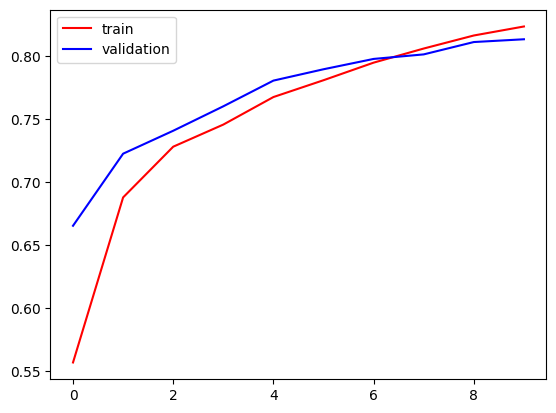

In [26]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],color = 'red', label='train')
plt.plot(history.history['val_accuracy'],color = 'blue', label='validation')
plt.legend()
plt.show()

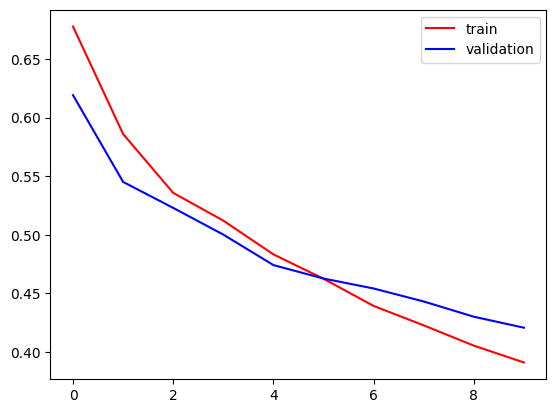

In [27]:
plt.plot(history.history['loss'],color = 'red', label='train')
plt.plot(history.history['val_loss'],color = 'blue', label='validation')
plt.legend()
plt.show()